In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score


In [2]:
# Load datasets
customers_df = pd.read_csv("Customers.csv")
transactions_df = pd.read_csv("Transactions.csv")


In [3]:
# Convert dates to datetime
customers_df["SignupDate"] = pd.to_datetime(customers_df["SignupDate"])
transactions_df["TransactionDate"] = pd.to_datetime(transactions_df["TransactionDate"])


In [4]:
# Aggregate transaction data at customer level
customer_transactions = transactions_df.groupby("CustomerID").agg(
    TotalSpent=pd.NamedAgg(column="TotalValue", aggfunc="sum"),
    TotalTransactions=pd.NamedAgg(column="TransactionID", aggfunc="count"),
    TotalQuantity=pd.NamedAgg(column="Quantity", aggfunc="sum"),
    LastPurchaseDate=pd.NamedAgg(column="TransactionDate", aggfunc="max")
).reset_index()

In [5]:
# Merge with customer profile data
customer_data = pd.merge(customers_df, customer_transactions, on="CustomerID", how="left")

# Calculate additional features
customer_data["CustomerTenure"] = (pd.to_datetime("today") - customer_data["SignupDate"]).dt.days
customer_data["Recency"] = (pd.to_datetime("today") - customer_data["LastPurchaseDate"]).dt.days

# Fill missing values for customers without transactions
customer_data.fillna({"TotalSpent": 0, "TotalTransactions": 0, "TotalQuantity": 0, "Recency": customer_data["Recency"].max()}, inplace=True)

# Drop unnecessary columns
customer_data.drop(columns=["CustomerName", "SignupDate", "LastPurchaseDate"], inplace=True)

# Encode 'Region'
encoder = LabelEncoder()
customer_data["Region"] = encoder.fit_transform(customer_data["Region"])

# Normalize numerical features
scaler = StandardScaler()
numerical_features = ["TotalSpent", "TotalTransactions", "TotalQuantity", "CustomerTenure", "Recency"]
customer_data[numerical_features] = scaler.fit_transform(customer_data[numerical_features])


In [6]:
# Prepare data for clustering
X = customer_data.drop(columns=["CustomerID"])

# Find optimal clusters using clustering metrics
cluster_range = range(2, 11)
db_scores = []
silhouette_scores = []
calinski_scores = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    
    db_index = davies_bouldin_score(X, labels)
    silhouette_avg = silhouette_score(X, labels)
    calinski_harabasz = calinski_harabasz_score(X, labels)

    db_scores.append(db_index)
    silhouette_scores.append(silhouette_avg)
    calinski_scores.append(calinski_harabasz)

    print(f"Clusters: {k} | DB Index: {db_index:.4f} | Silhouette Score: {silhouette_avg:.4f} | Calinski-Harabasz: {calinski_harabasz:.4f}")


Clusters: 2 | DB Index: 1.4825 | Silhouette Score: 0.2386 | Calinski-Harabasz: 80.6266
Clusters: 3 | DB Index: 1.3605 | Silhouette Score: 0.2401 | Calinski-Harabasz: 67.6539
Clusters: 4 | DB Index: 1.3205 | Silhouette Score: 0.2332 | Calinski-Harabasz: 66.9287
Clusters: 5 | DB Index: 1.3027 | Silhouette Score: 0.2424 | Calinski-Harabasz: 65.1364
Clusters: 6 | DB Index: 1.2268 | Silhouette Score: 0.2507 | Calinski-Harabasz: 65.0248
Clusters: 7 | DB Index: 1.2417 | Silhouette Score: 0.2289 | Calinski-Harabasz: 61.1068
Clusters: 8 | DB Index: 1.2150 | Silhouette Score: 0.2284 | Calinski-Harabasz: 58.8343
Clusters: 9 | DB Index: 1.2256 | Silhouette Score: 0.2232 | Calinski-Harabasz: 57.7251
Clusters: 10 | DB Index: 1.2650 | Silhouette Score: 0.2198 | Calinski-Harabasz: 54.3708


In [7]:
# Identify optimal number of clusters based on lowest DB Index
optimal_clusters = cluster_range[db_scores.index(min(db_scores))]
optimal_db_index = min(db_scores)

print(f"\nOptimal Clusters: {optimal_clusters} (Lowest DB Index: {optimal_db_index:.4f})")



Optimal Clusters: 8 (Lowest DB Index: 1.2150)


In [8]:
# Apply KMeans with optimal clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
customer_data["Cluster"] = kmeans.fit_predict(X)

In [9]:
# Reduce dimensions to 2D using PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
customer_data["PCA1"] = X_pca[:, 0]
customer_data["PCA2"] = X_pca[:, 1]

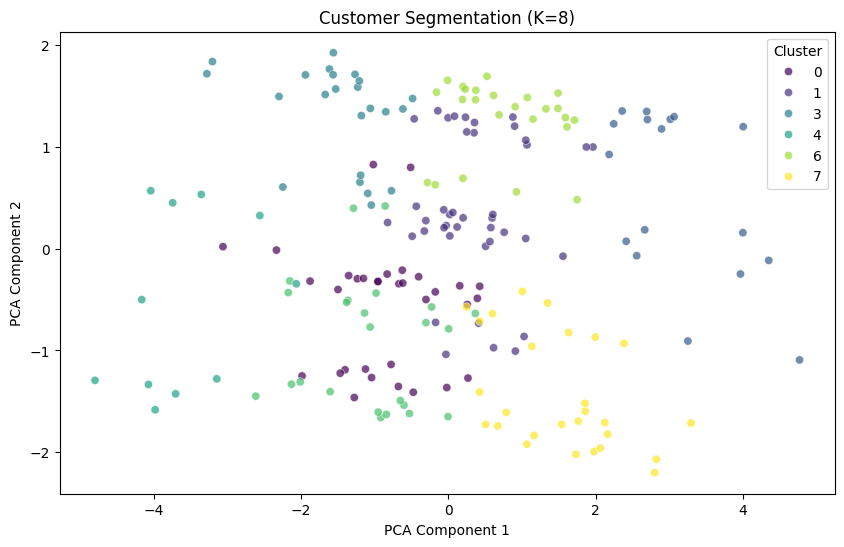

In [10]:
# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x="PCA1", y="PCA2", hue="Cluster", palette="viridis", data=customer_data, alpha=0.7)
plt.title(f"Customer Segmentation (K={optimal_clusters})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()